In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

In [4]:
cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv("/content/drive/MyDrive/DataSets/Sentiment/Sentiment140/Sentiment_Analysis_Dataset_10k.csv",header=None, names=cols)
# above line will be different depending on where you saved your data, and your file name
df.head()

sentiment          id                          date query_string  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009     NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009     NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009     NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009     NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009     NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [5]:
df.sentiment.value_counts()

0    5002
4    4999
Name: sentiment, dtype: int64

In [6]:
df.drop(['id','date','query_string','user'],axis=1,inplace=True)

In [7]:
df[df.sentiment == 0].head(10)

sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....
5          0                      @Kwesidei not the whole crew 
6          0                                        Need a hug 
7          0  @LOLTrish hey  long time no see! Yes.. Rains a...
8          0               @Tatiana_K nope they didn't have it 
9          0                          @twittera que me muera ?

In [8]:
df[df.sentiment == 4].head(10)

sentiment                                               text
5002          4       I LOVE @Health4UandPets u guys r the best!! 
5003          4  im meeting up with one of my besties tonight! ...
5004          4  @DaRealSunisaKim Thanks for the Twitter add, S...
5005          4  Being sick can be really cheap when it hurts t...
5006          4    @LovesBrooklyn2 he has that effect on everyone 
5007          4  @ProductOfFear You can tell him that I just bu...
5008          4  @r_keith_hill Thans for your response. Ihad al...
5009          4  @KeepinUpWKris I am so jealous, hope you had a...
5010          4  @tommcfly ah, congrats mr fletcher for finally...
5011          4  @e4VoIP I RESPONDED  Stupid cat is helping me ...

In [9]:
df['pre_clean_len'] = [len(t) for t in df.text]

In [10]:
from pprint import pprint
data_dict = {
    'sentiment':{
        'type':df.sentiment.dtype,
        'description':'sentiment class - 0:negative, 4:positive'
    },
    'text':{
        'type':df.text.dtype,
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':df.pre_clean_len.dtype,
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':df.shape
}
pprint(data_dict)

{'dataset_shape': (10001, 3),
 'pre_clean_len': {'description': 'Length of the tweet before cleaning',
                   'type': dtype('int64')},
 'sentiment': {'description': 'sentiment class - 0:negative, 4:positive',
               'type': dtype('int64')},
 'text': {'description': 'tweet text', 'type': dtype('O')}}


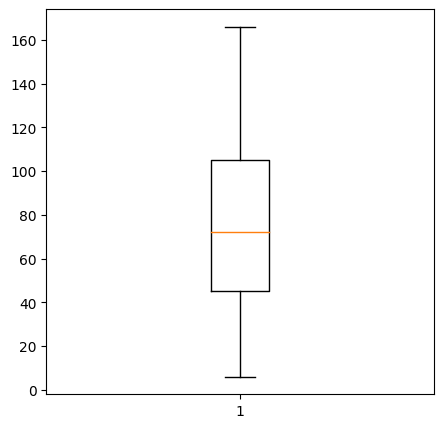

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

In [12]:
df[df.pre_clean_len > 140].head(10)

sentiment                                               text  \
213           0  Awwh babs... you look so sad underneith that s...   
279           0  Whinging. My client&amp;boss don't understand ...   
343           0  @TheLeagueSF Not Fun &amp; Furious? The new ma...   
400           0  #3 woke up and was having an accident - &quot;...   
464           0  My bathtub drain is fired: it haz 1 job 2 do, ...   
492           0  pears &amp; Brie, bottle of Cabernet, and &quo...   
747           0  Have an invite for &quot;Healthy Dining&quot; ...   
957           0  Damnit I was really digging this season of Rea...   
1064          0  Why do I keep looking...I know that what I rea...   
1071          0  Used the term &quot;Fail Whale&quot; to a clie...   

      pre_clean_len  
213             142  
279             145  
343             145  
400             144  
464             146  
492             150  
747             141  
957             141  
1064            141  
1071            148

In [13]:
#Data Preparation 1: HTML decoding

from bs4 import BeautifulSoup
example1 = BeautifulSoup(df.text[279], 'lxml')
print (example1.get_text())

Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


In [14]:
#Data Preparation 2: ‘@’mention

import re
re.sub(r'@[A-Za-z0-9]+','',df.text[343])

' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [15]:
#Data Preparation 3: URL links

re.sub('https?://[A-Za-z0-9./]+','',df.text[0])

"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [16]:
df.text[226]

'Tuesday�ll start with reflection �n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [17]:
#Data Preparation 4: UTF-8 BOM (Byte Order Mark)

testing = df.text[226].encode().decode("utf-8-sig")
testing

'Tuesday�ll start with reflection �n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [18]:
testing.replace(u"\ufffd", "?")

'Tuesday?ll start with reflection ?n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [19]:
df.text[175]

"@machineplay I'm so sorry you're having to go through this. Again.  #therapyfail"

In [20]:
#Data Preparation 5: hashtag / numbers

re.sub("[^a-zA-Z]", " ", df.text[175])

' machineplay I m so sorry you re having to go through this  Again    therapyfail'

In [21]:
#Defining data cleaning function

from nltk.tokenize import WordPunctTokenizer     #or can use WordNetLemmatizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()
testing = df.text[:100]
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))
test_result

<ipython-input-21-3ceb8d26d98f>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml')


['awww that s a bummer you shoulda got david carr of third day to do it d',
 'is upset that he can t update his facebook by texting it and might cry as a result school today also blah',
 'i dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no it s not behaving at all i m mad why am i here because i can t see you all over there',
 'not the whole crew',
 'need a hug',
 'hey long time no see yes rains a bit only a bit lol i m fine thanks how s you',
 'k nope they didn t have it',
 'que me muera',
 'spring break in plain city it s snowing',
 'i just re pierced my ears',
 'i couldn t bear to watch it and i thought the ua loss was embarrassing',
 'it it counts idk why i did either you never talk to me anymore',
 'i would ve been the first but i didn t have a gun not really though zac snyder s just a doucheclown',
 'i wish i got to watch it with you i miss you and how was the premiere',
 'hollis death scene will hurt

In [22]:
nums = [0,5000,10000]   #change batch sizes
print ("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(nums[0],nums[2]):
    if( (i+1)%1000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, nums[2] ))
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the tweets...



<ipython-input-21-3ceb8d26d98f>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml')


Tweets 1000 of 10000 has been processed
Tweets 2000 of 10000 has been processed
Tweets 3000 of 10000 has been processed
Tweets 4000 of 10000 has been processed
Tweets 5000 of 10000 has been processed
Tweets 6000 of 10000 has been processed
Tweets 7000 of 10000 has been processed
Tweets 8000 of 10000 has been processed
Tweets 9000 of 10000 has been processed
Tweets 10000 of 10000 has been processed


In [23]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment
clean_df.head()

text  target
0  awww that s a bummer you shoulda got david car...       0
1  is upset that he can t update his facebook by ...       0
2  i dived many times for the ball managed to sav...       0
3     my whole body feels itchy and like its on fire       0
4  no it s not behaving at all i m mad why am i h...       0

In [24]:
clean_df.to_csv('clean_tweet.csv',encoding='utf-8')
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

text  target
0  awww that s a bummer you shoulda got david car...       0
1  is upset that he can t update his facebook by ...       0
2  i dived many times for the ball managed to sav...       0
3     my whole body feels itchy and like its on fire       0
4  no it s not behaving at all i m mad why am i h...       0

In [25]:
# Re-cleaning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [26]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

text  target
0  awww that s a bummer you shoulda got david car...       0
1  is upset that he can t update his facebook by ...       0
2  i dived many times for the ball managed to sav...       0
3     my whole body feels itchy and like its on fire       0
4  no it s not behaving at all i m mad why am i h...       0

In [27]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9970 non-null   object
 1   target  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 234.4+ KB


In [28]:
#Null Removal

my_df[my_df.isnull().any(axis=1)].head()

text  target
208   NaN       0
249   NaN       0
398   NaN       0
430   NaN       0
1011  NaN       0

In [29]:
np.sum(my_df.isnull().any(axis=1))

30

In [30]:
my_df.isnull().any(axis=0)

text       True
target    False
dtype: bool

In [31]:
df = pd.read_csv("/content/drive/MyDrive/DataSets/Sentiment/Sentiment140/Sentiment_Analysis_Dataset_10k.csv",header=None)
df.iloc[my_df[my_df.isnull().any(axis=1)].index,:].head()

0           1                             2         3             4  \
208   0  1467863072  Mon Apr 06 22:33:25 PDT 2009  NO_QUERY      Artiel87   
249   0  1467874569  Mon Apr 06 22:36:27 PDT 2009  NO_QUERY      Artiel87   
398   0  1467912842  Mon Apr 06 22:46:53 PDT 2009  NO_QUERY  KimberlyKane   
430   0  1467919452  Mon Apr 06 22:48:48 PDT 2009  NO_QUERY     jtmal0723   
1011  0  1468061127  Mon Apr 06 23:30:23 PDT 2009  NO_QUERY    gabysslave   

                   5  
208       @mandayyy   
249     @mandayyy     
398   @danadearmond   
430       @anistorm   
1011  @citizensheep

In [32]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9970 entries, 0 to 9969
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9970 non-null   object
 1   target  9970 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 155.9+ KB


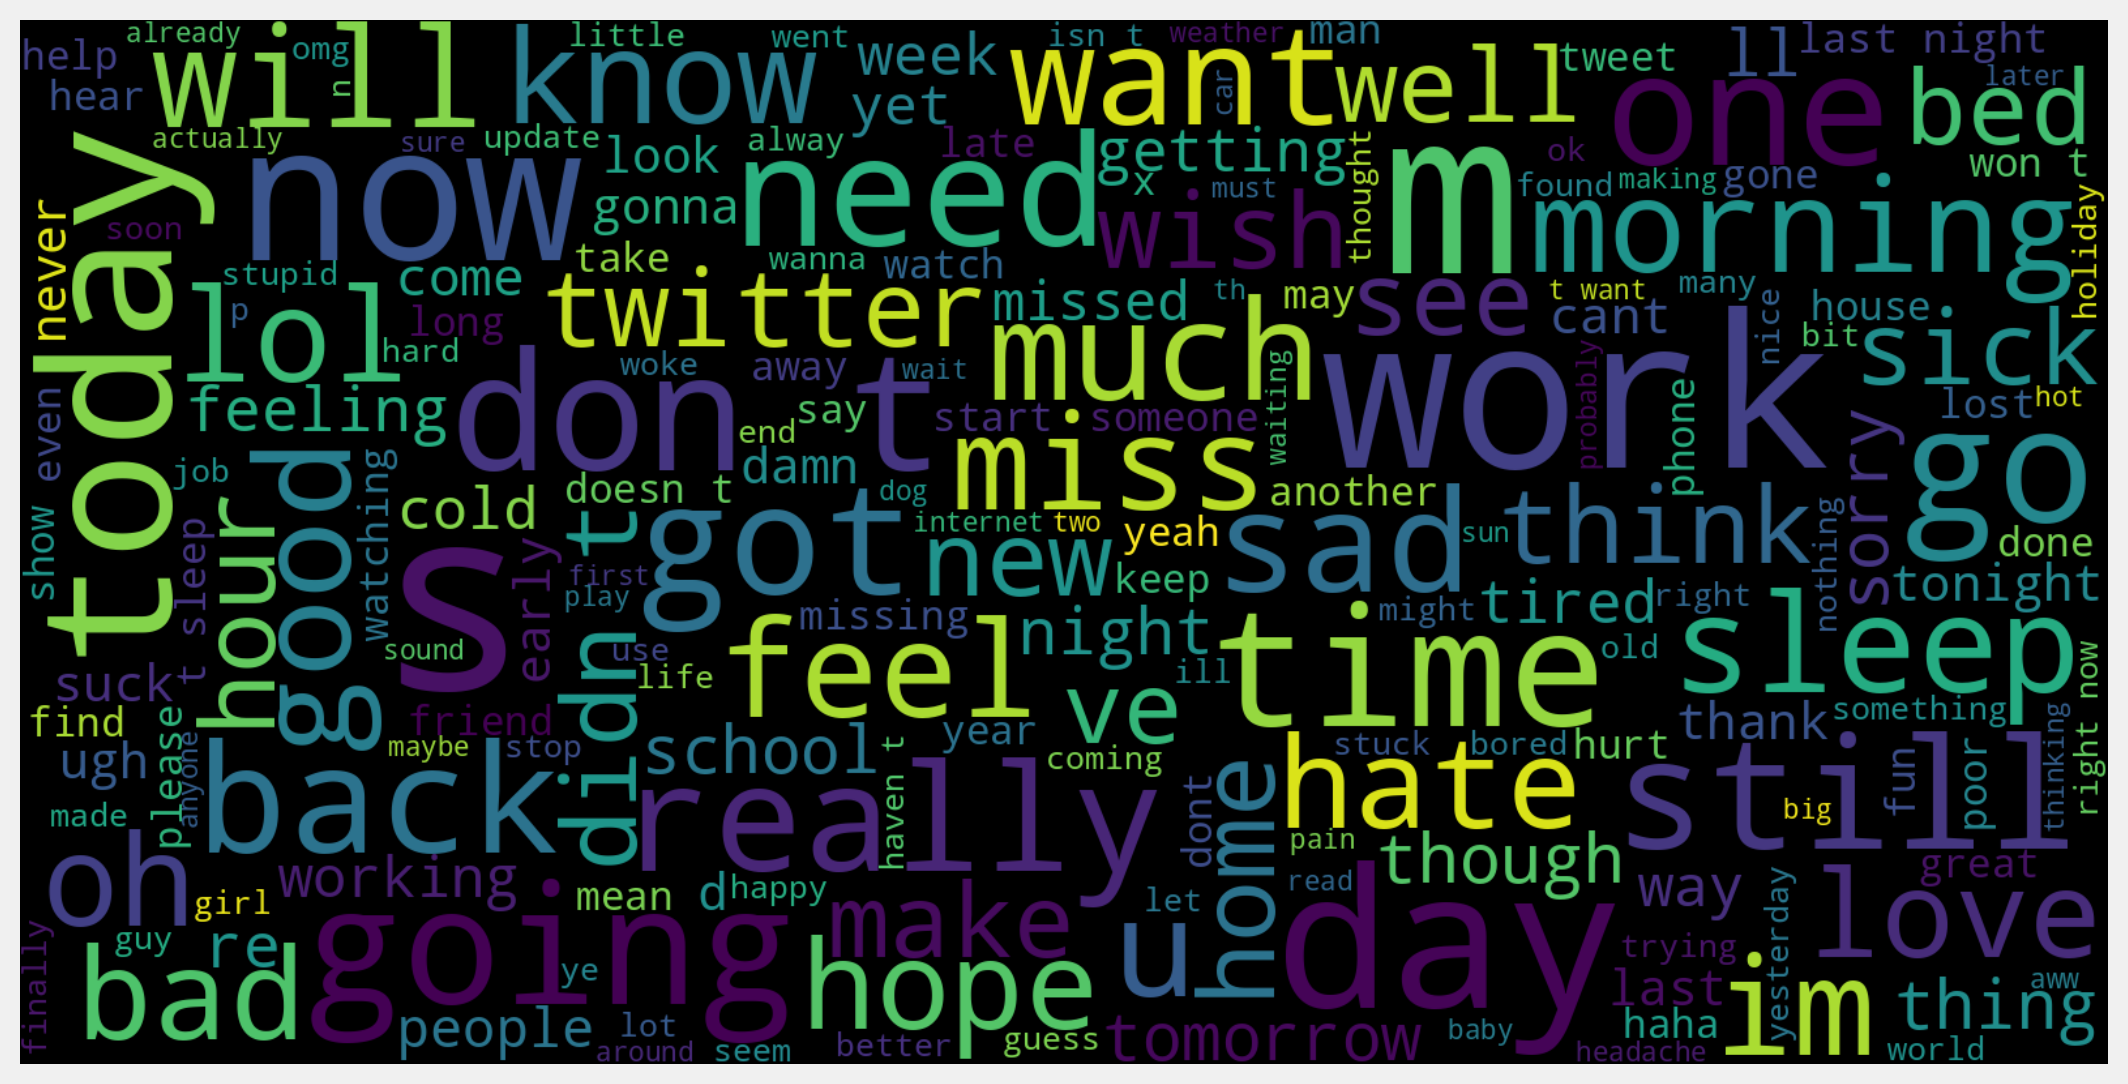

In [33]:
# Text Visualisation with WORDCLOUD

neg_tweets = my_df[my_df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [34]:
for t in neg_tweets.text[:200]:
    if 'love' in t:
        print (t)

ahh ive always wanted to see rent love the soundtrack
meh almost lover is the exception this track gets me depressed every time
awe i love you too am here i miss you
damn the grind is inspirational and saddening at the same time don t want you to stop cuz i like what u do much love
i m missing you babe but as long as your alive i m happy yawwwnn i m tired my love imma try to sleep hopefully you had a headstart
love the french i tell people here in the south i m qtr french and they snarl at me french are beautiful people


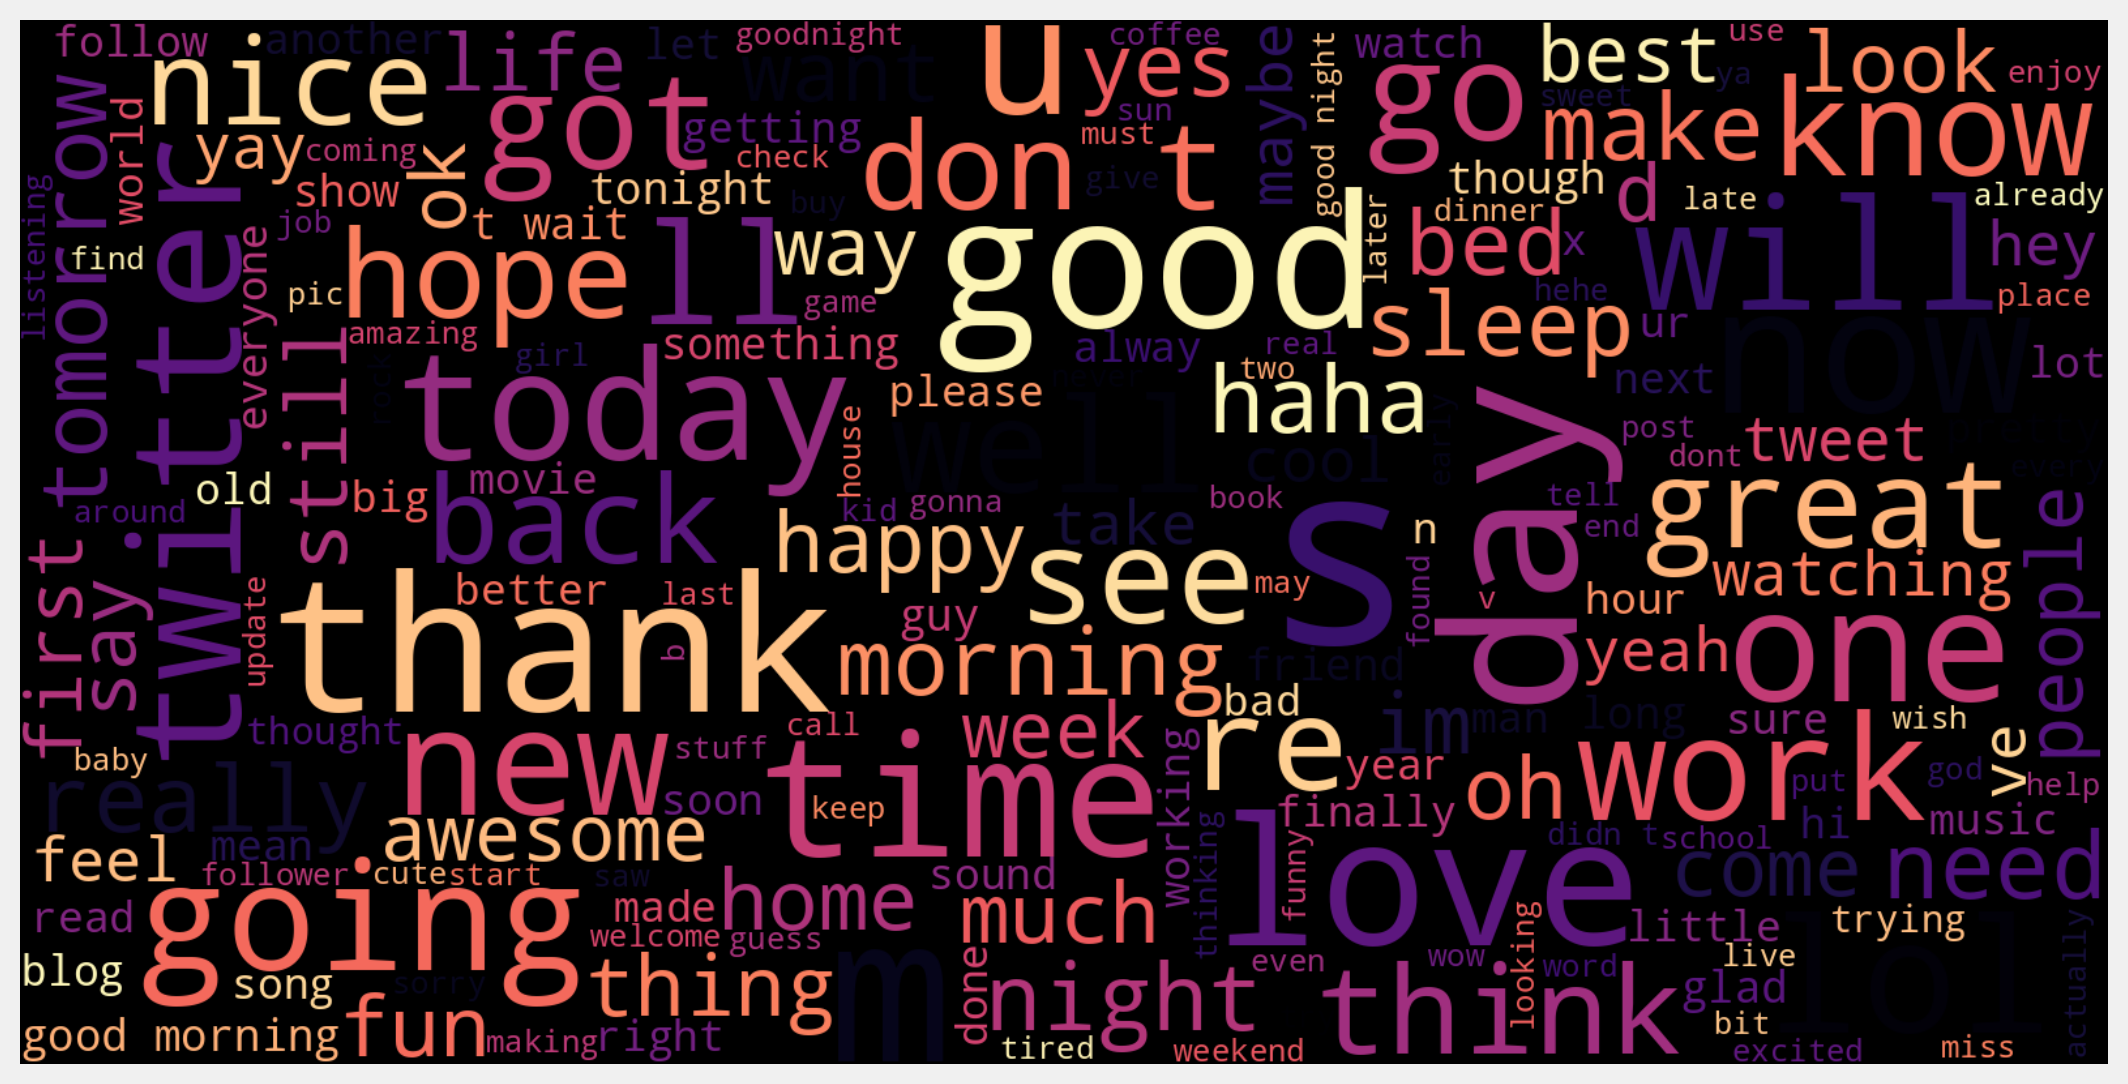

In [35]:
pos_tweets = my_df[my_df.target == 4]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [36]:
# Data Visualisation
from sklearn.feature_extraction.text import CountVectorizer    #or can use TfidfVectorizer
cvec = CountVectorizer()
cvec.fit(my_df.text)

CountVectorizer()

In [37]:
len(cvec.get_feature_names_out())

13352

In [38]:
#get frequency from Sparse matrix

neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names_out()).transpose()

In [39]:
document_matrix = cvec.transform(my_df.text)
my_df[my_df.target == 0].tail()

text  target
4985                             i am fine thanks tired       0
4986            trying to keep my eyes open damn baking       0
4987                         why the hell is it snowing       0
4988  gisburn is great there are some nice little si...       0
4989  has to resit exams over summer wishes he worke...       0

In [40]:
%%time
neg_batches = np.linspace(0,4989,100).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(neg_batches)-2):
        print (neg_batches[i+1],"entries' term freuquency calculated")
    i += 1

50 entries' term freuquency calculated
554 entries' term freuquency calculated
1058 entries' term freuquency calculated
1562 entries' term freuquency calculated
2066 entries' term freuquency calculated
2570 entries' term freuquency calculated
3074 entries' term freuquency calculated
3577 entries' term freuquency calculated
4081 entries' term freuquency calculated
4585 entries' term freuquency calculated
4989 entries' term freuquency calculated
CPU times: user 109 ms, sys: 3.76 ms, total: 113 ms
Wall time: 125 ms


In [41]:
my_df.tail()

text  target
9965  lol i try maybe not hard enough lol i m at the...       4
9966  yay watching phineas pherb in bed i love this ...       4
9967  thanks for sending us the package got it this ...       4
9968  hahahha u obviously don t hv one but maybe u c...       4
9969  it s an internet term but it s spilled over in...       4

In [42]:
%%time
pos_batches = np.linspace(4989,9969,100).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(pos_batches)-2):
        print (pos_batches[i+1],"entries' term freuquency calculated")
    i += 1

5039 entries' term freuquency calculated
5542 entries' term freuquency calculated
6045 entries' term freuquency calculated
6548 entries' term freuquency calculated
7051 entries' term freuquency calculated
7554 entries' term freuquency calculated
8057 entries' term freuquency calculated
8560 entries' term freuquency calculated
9063 entries' term freuquency calculated
9566 entries' term freuquency calculated
9969 entries' term freuquency calculated
CPU times: user 108 ms, sys: 10 ms, total: 118 ms
Wall time: 133 ms


In [43]:
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names_out()).transpose()
term_freq_df.head()

0  1
aa           1  0
aaaaaaaa     1  0
aaaaaaaaaah  1  0
aaaaaaaaah   1  0
aaaaages     0  1

In [44]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

negative  positive  total
to       2025      1662   3687
the      1691      1655   3346
it        984      1024   2008
and      1018       955   1973
you       672      1257   1929
my       1066       775   1841
is        925       727   1652
for       671       803   1474
in        786       658   1444
of        634       633   1267

Text(0.5, 1.0, 'Top 500 tokens in tweets')

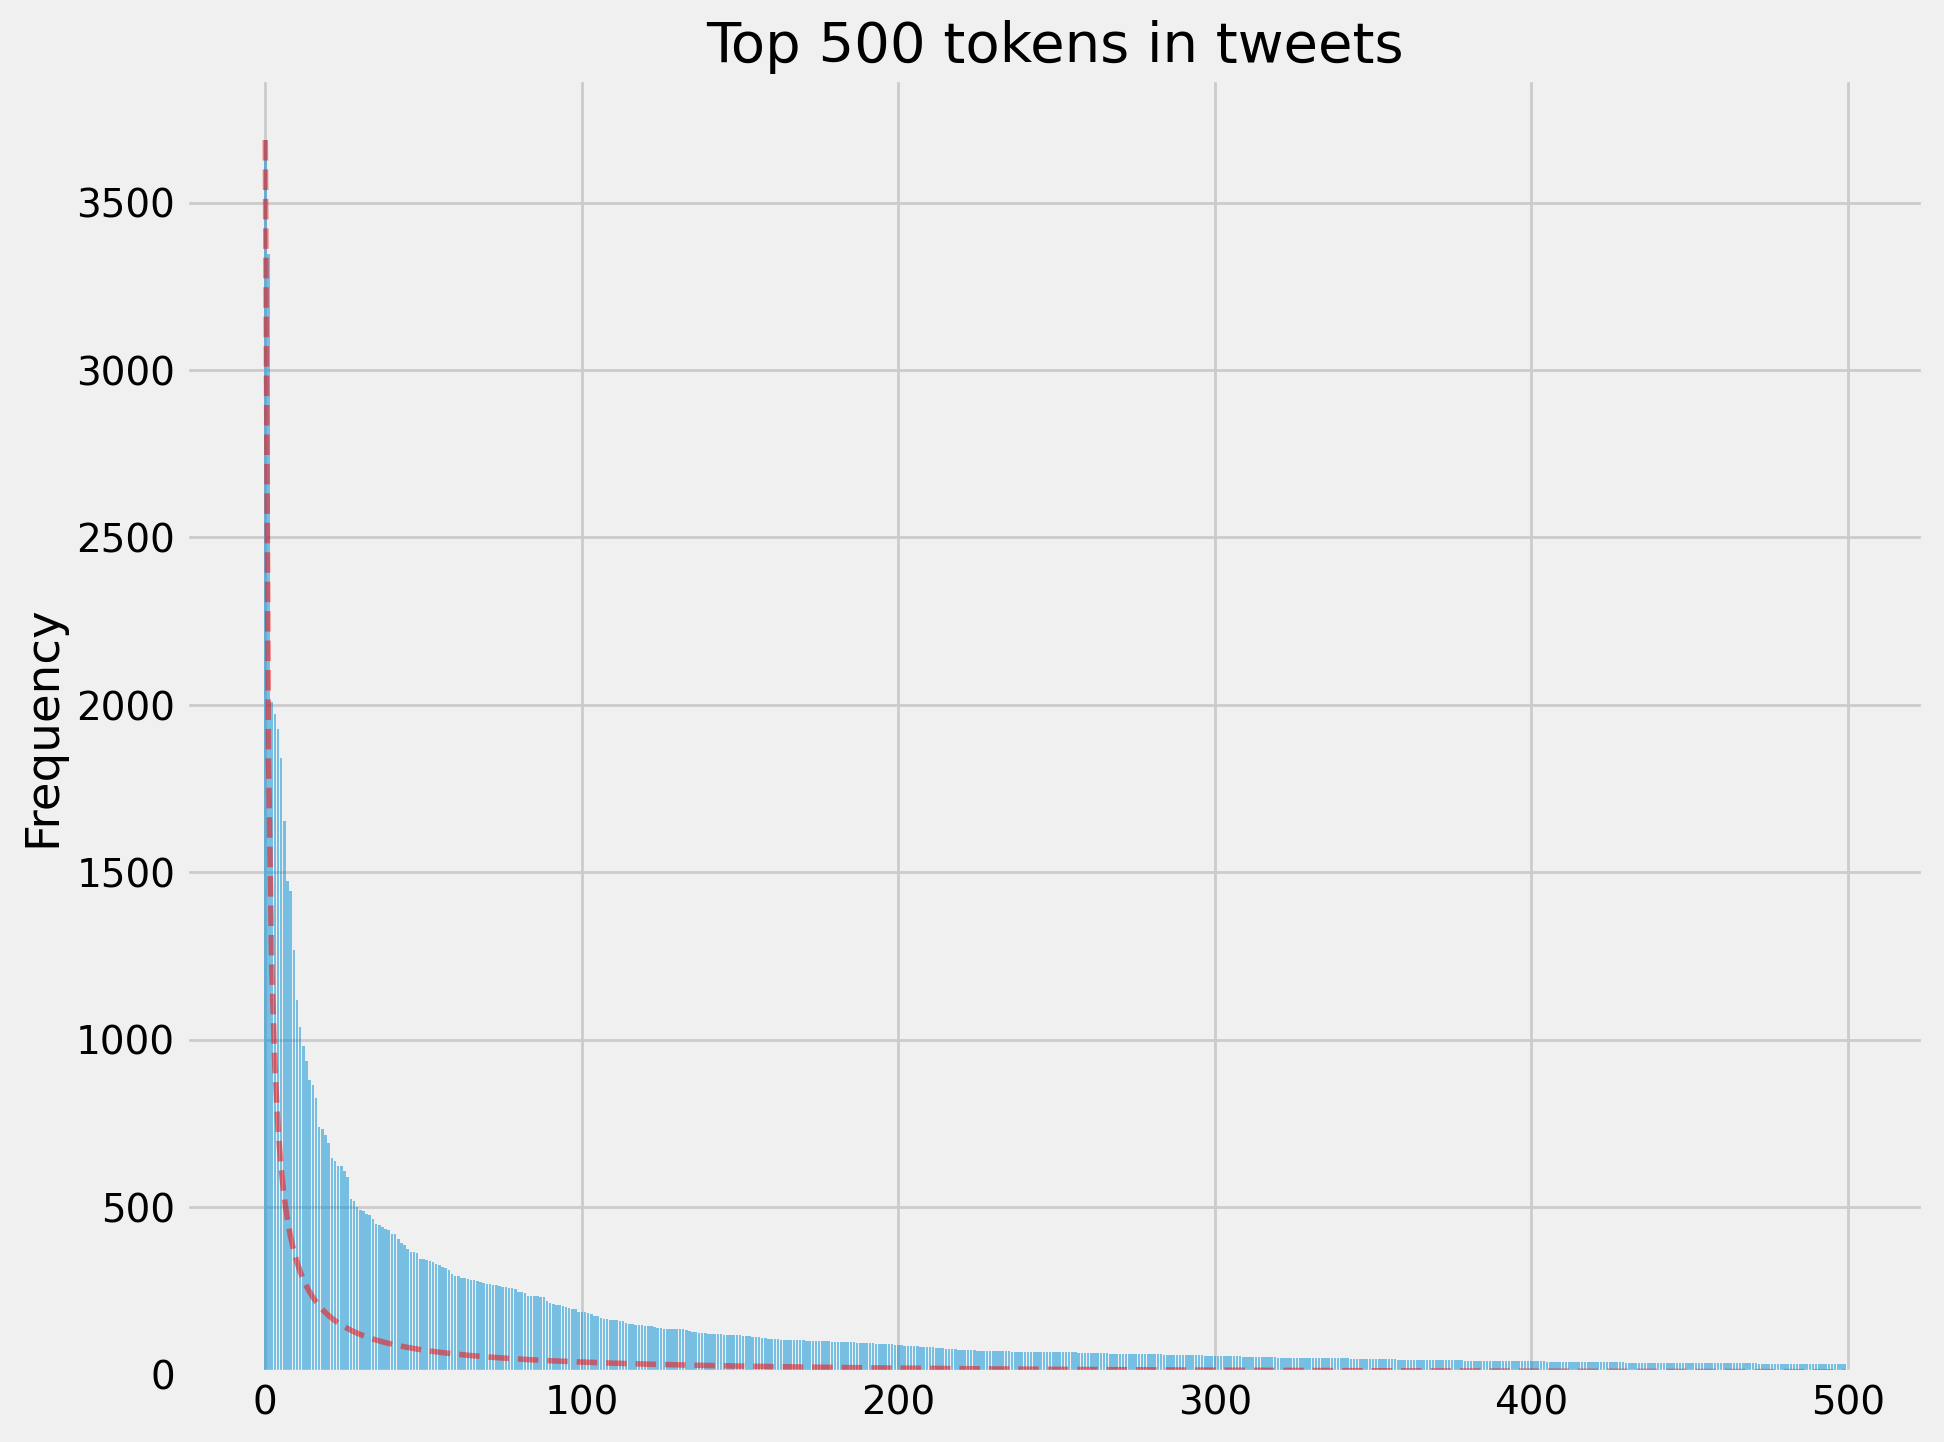

In [45]:
# Zipf's Law - - EDA
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

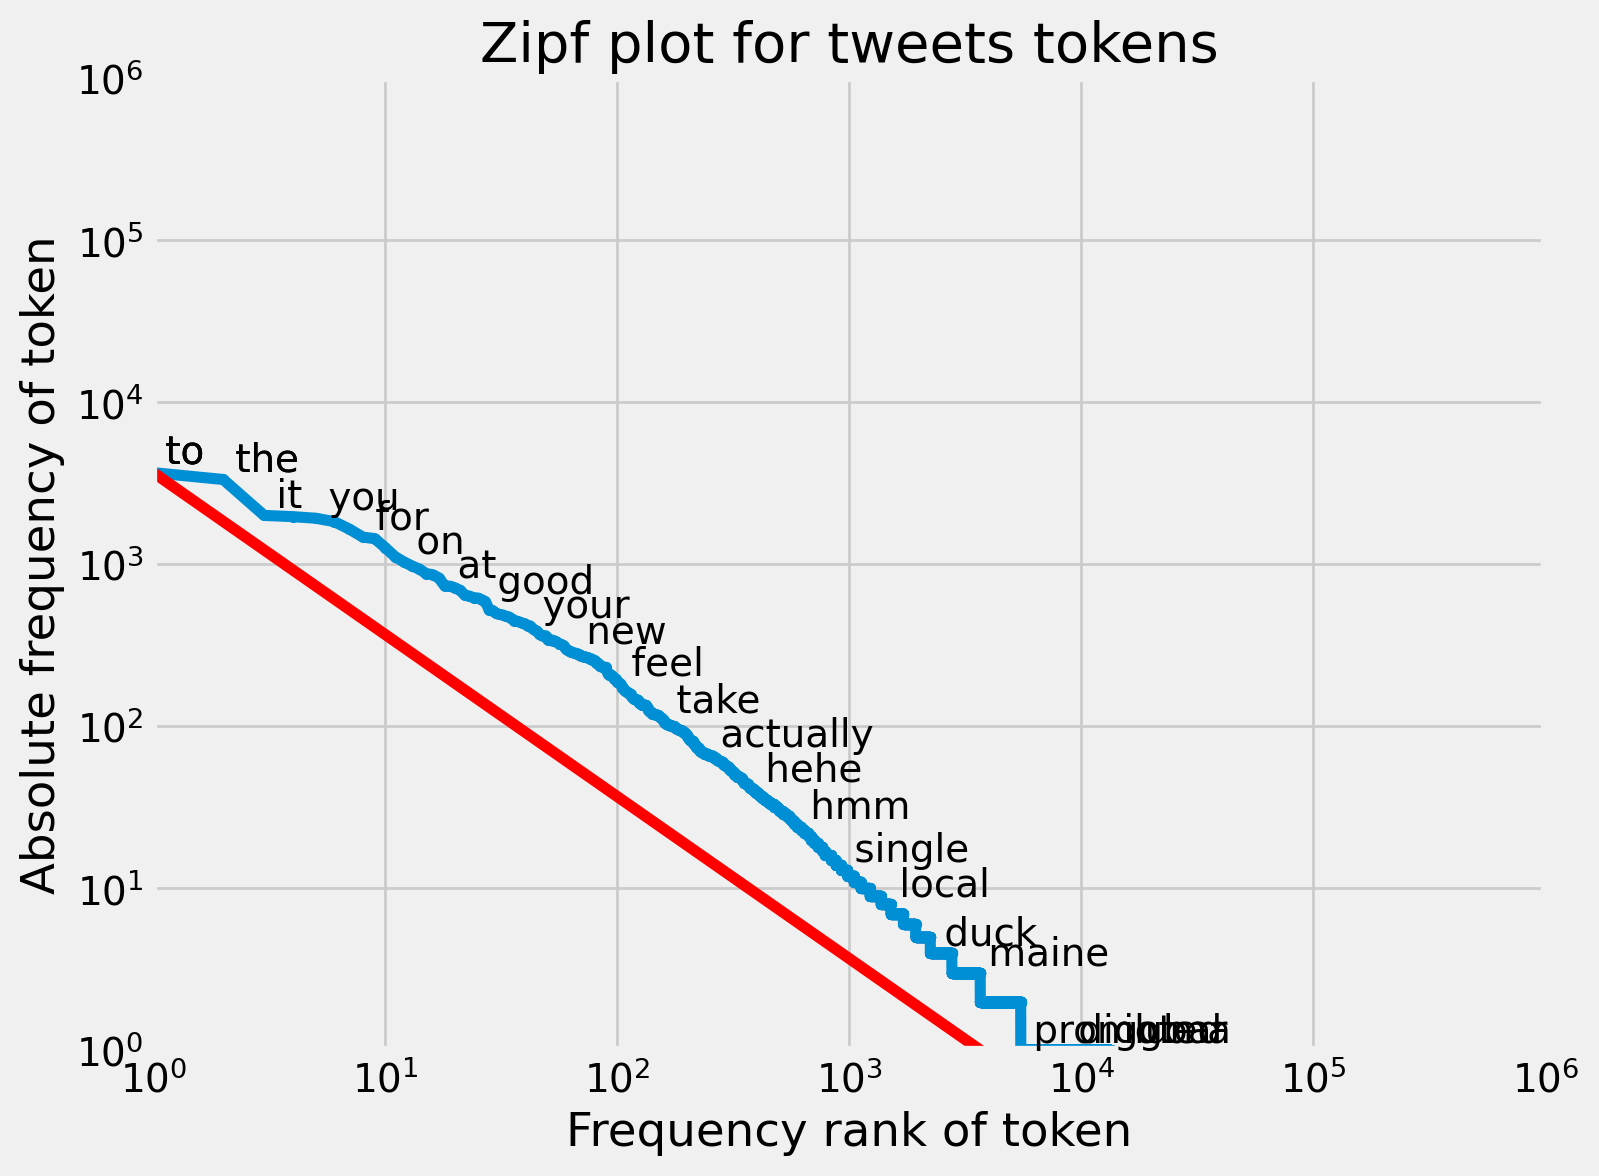

In [46]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]],
                 verticalalignment="bottom",
                 horizontalalignment="left")

In [47]:
term_freq_df.to_csv('term_freq_df.csv',encoding='utf-8')

In [48]:
term_freq_df2 = term_freq_df.copy()

Text(0.5, 1.0, 'Top 50 tokens in positive tweets')

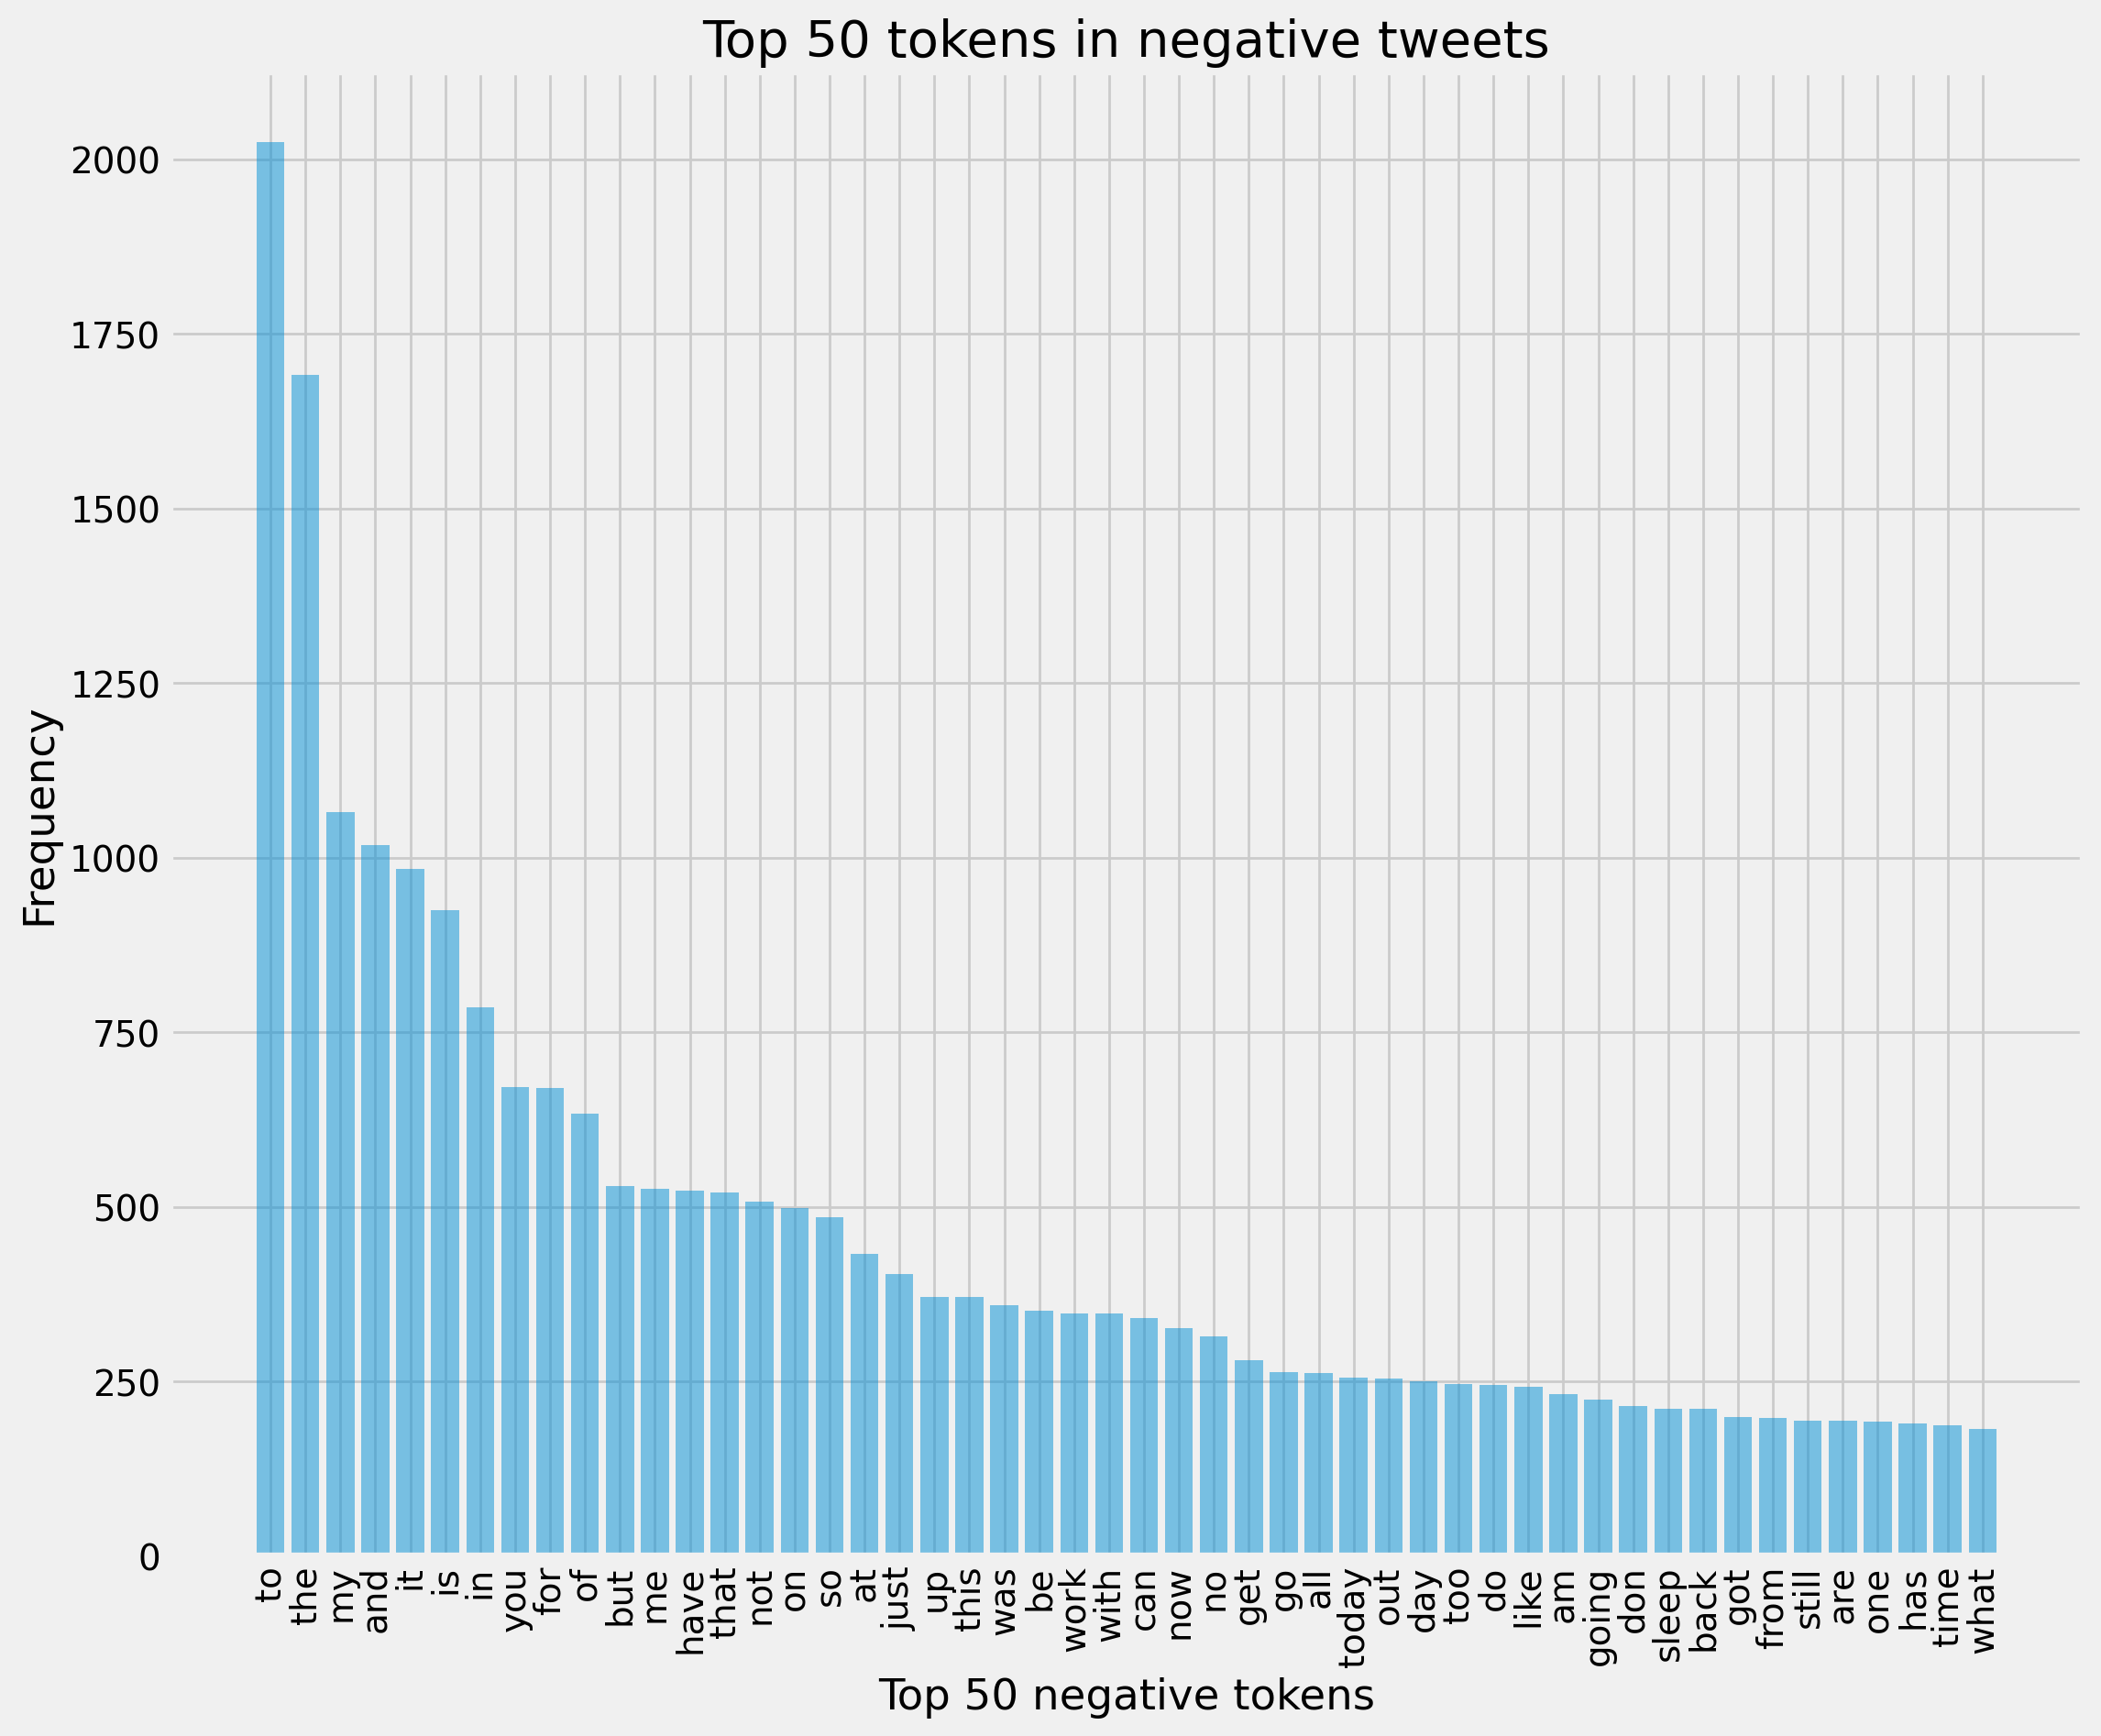

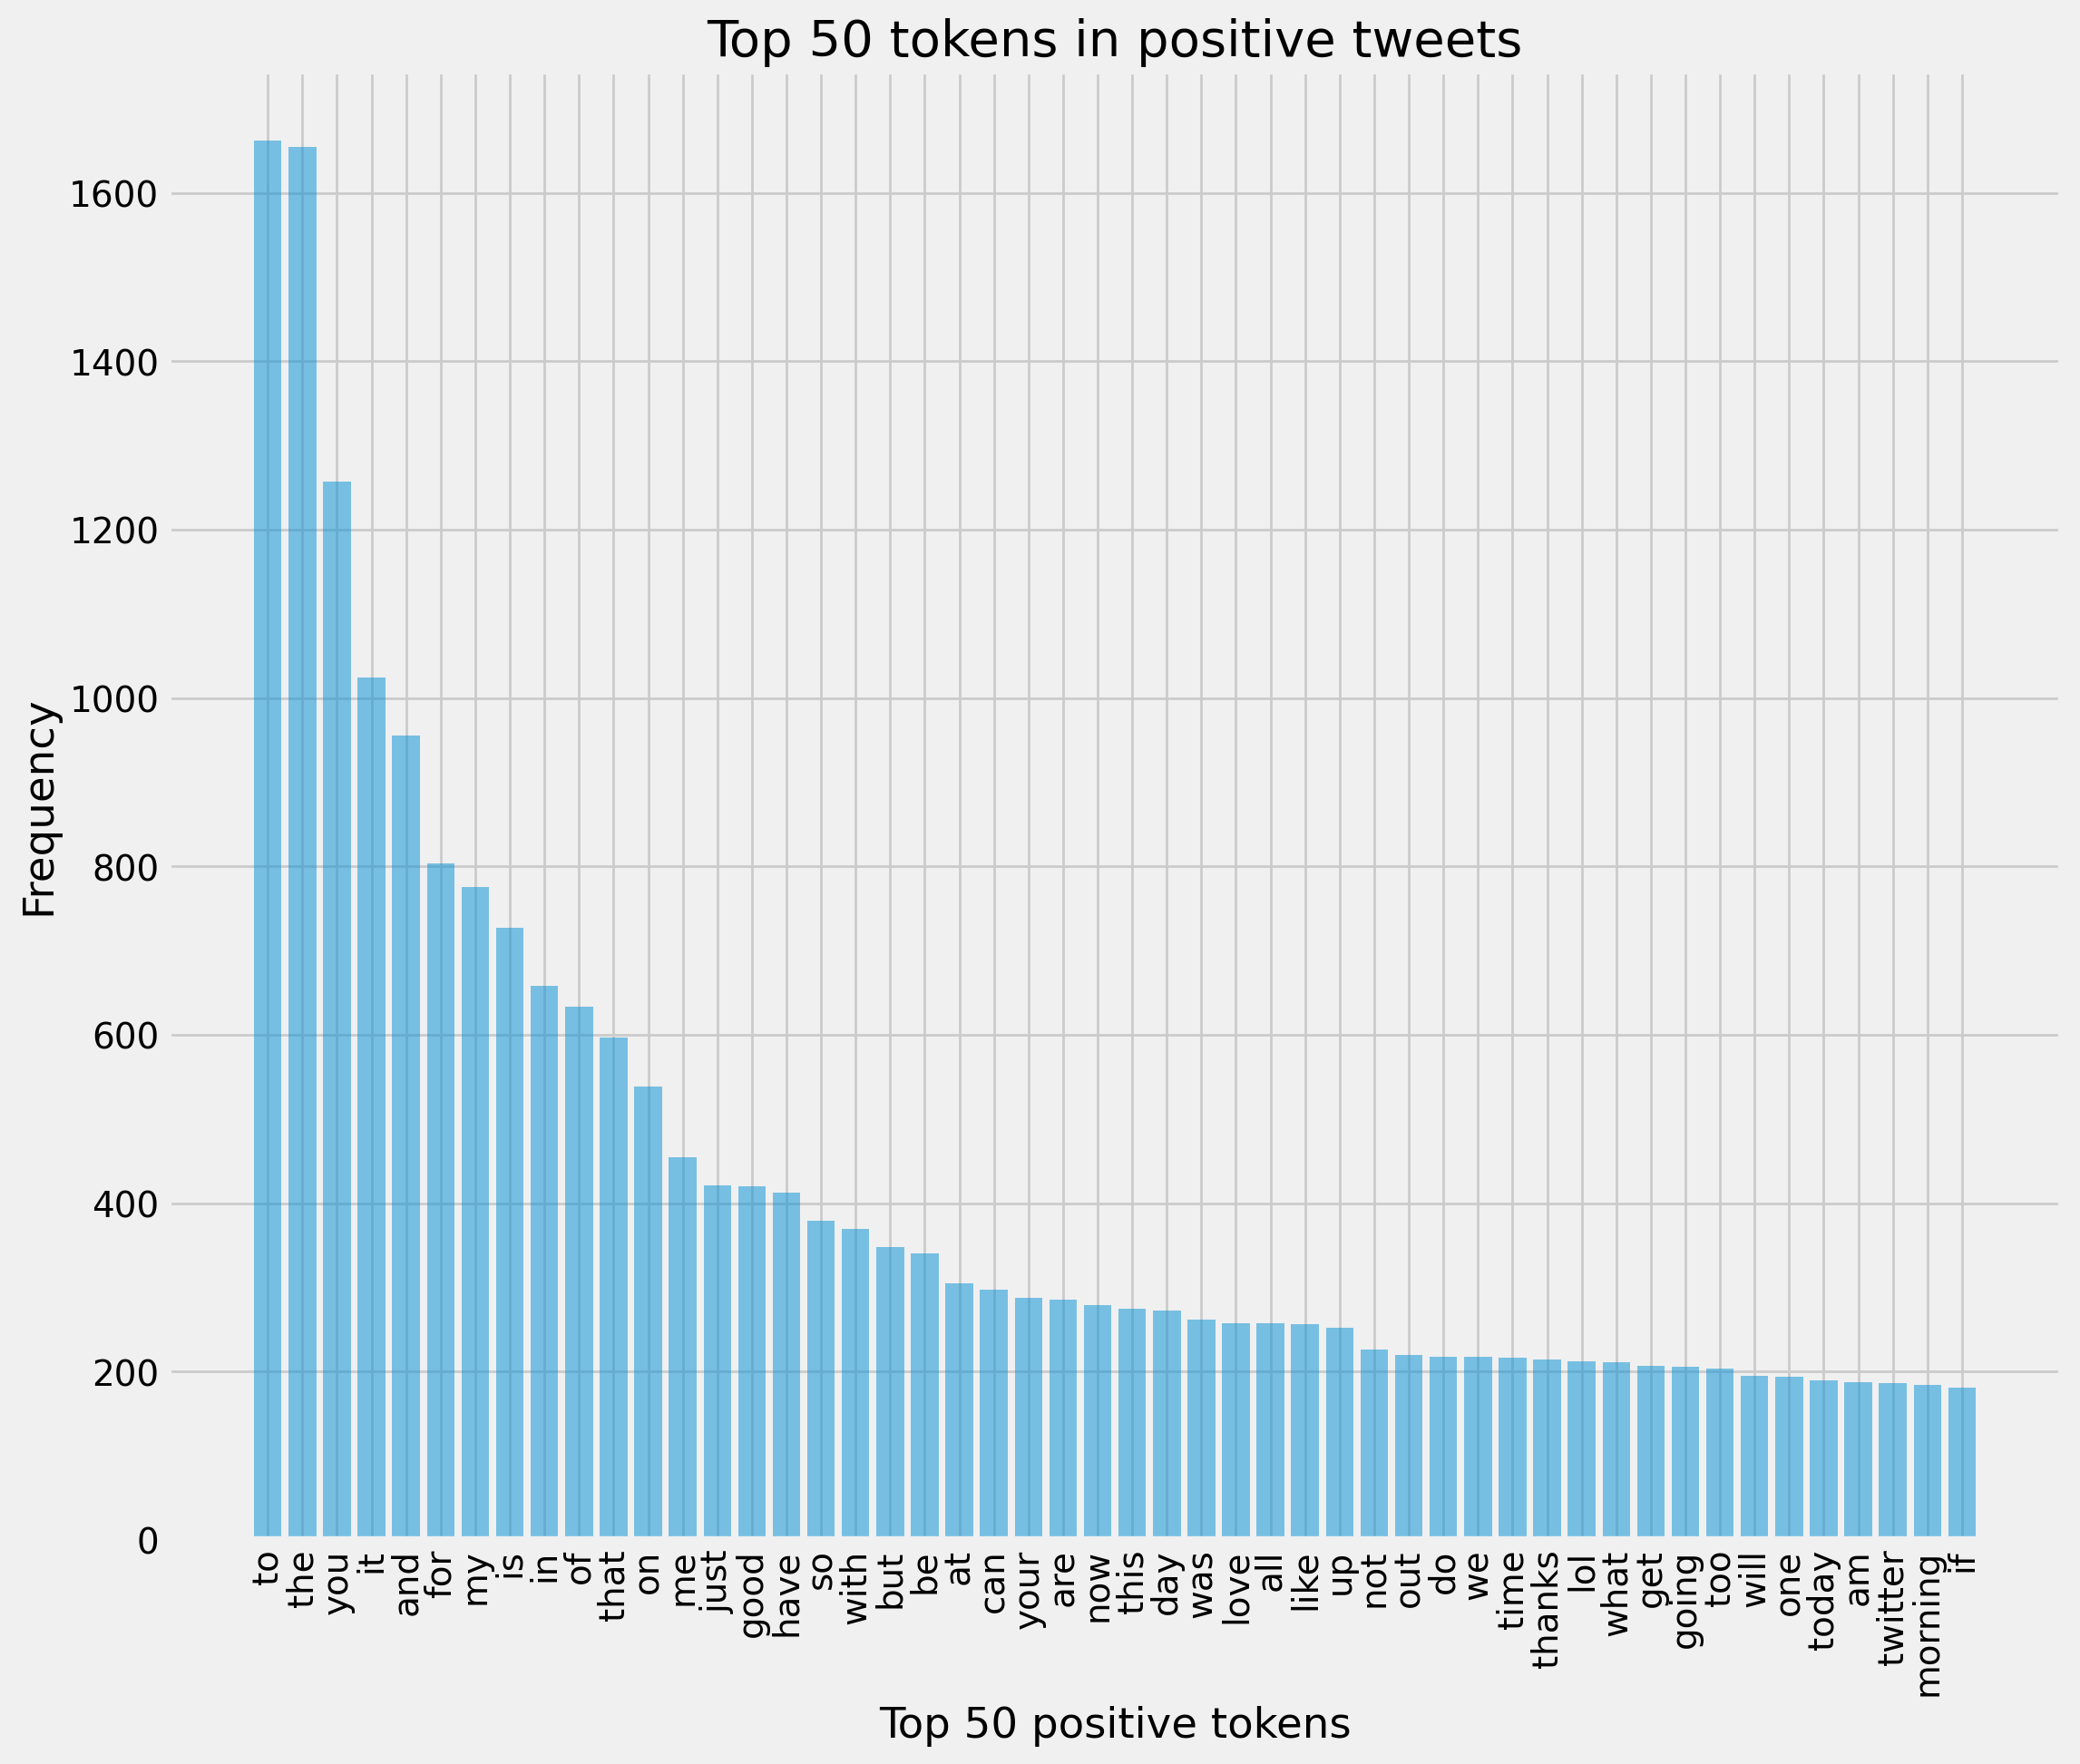

In [49]:
# Tweet Tokens Visualisation
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

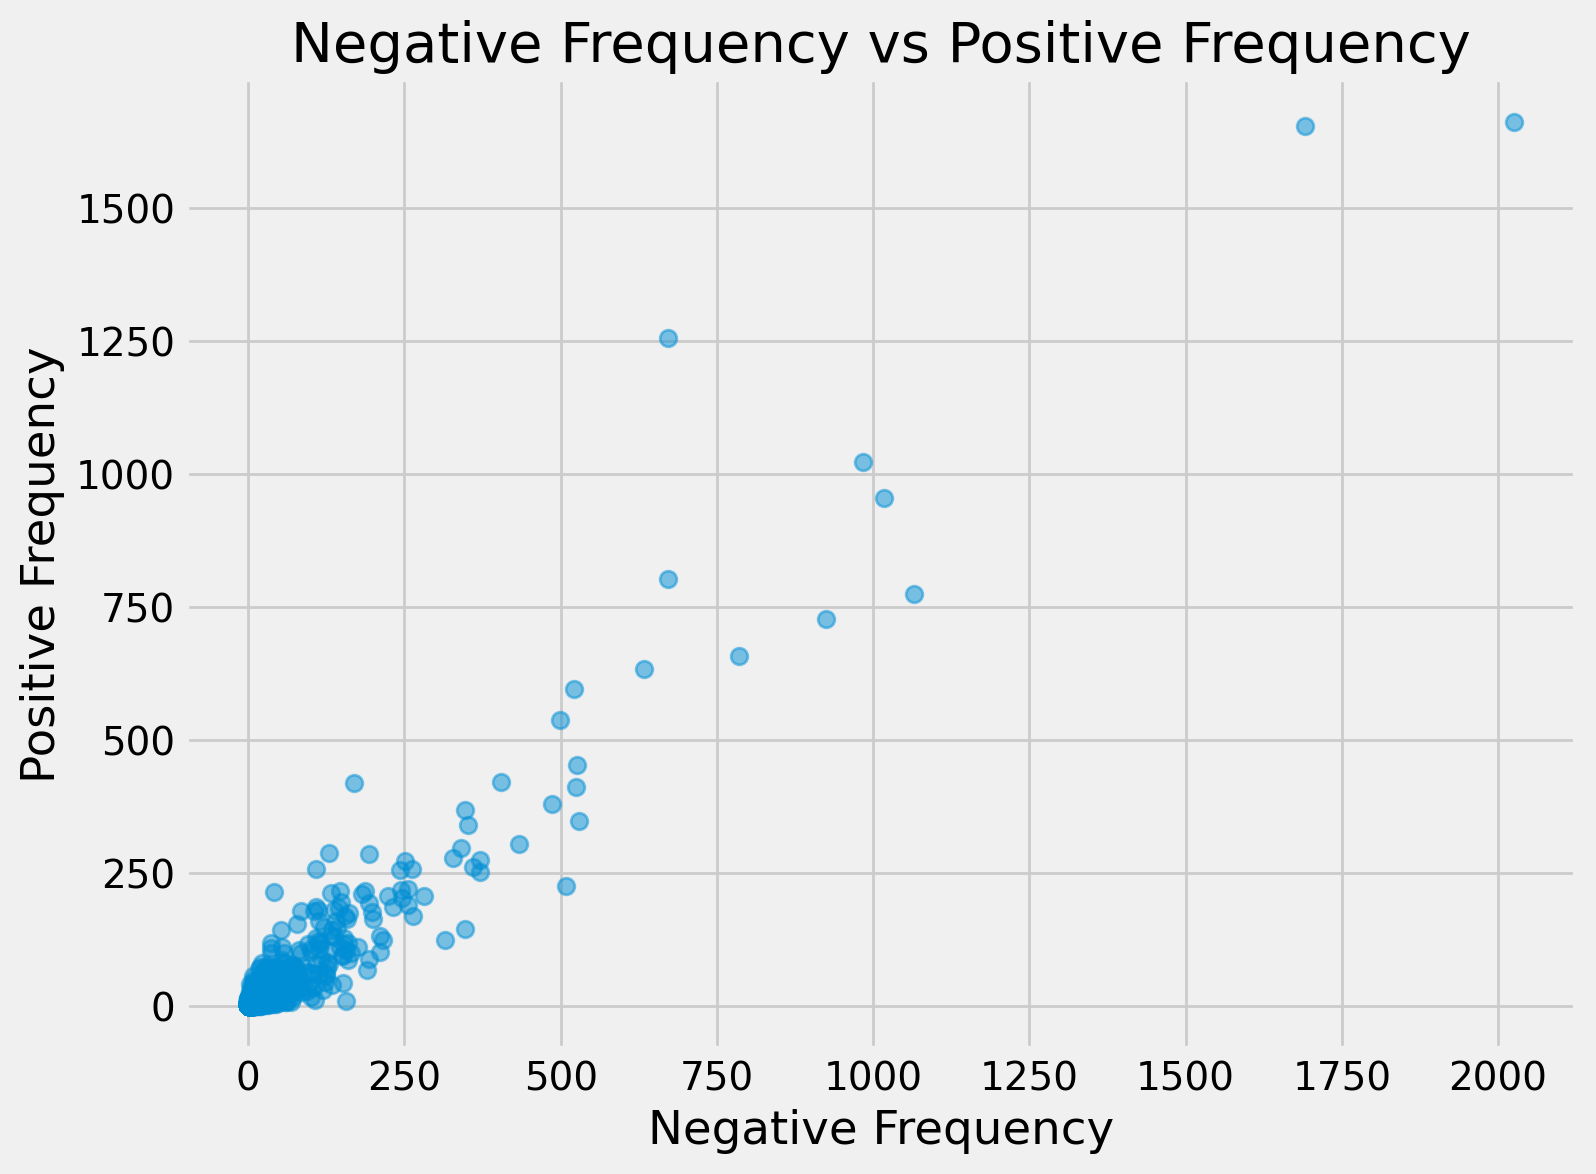

In [50]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

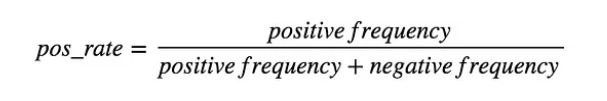

In [51]:
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

negative  positive  total  pos_rate
zzzzzzz          0         1      1       1.0
opdrpi           0         1      1       1.0
omfg             0         1      1       1.0
omgili           0         1      1       1.0
embarked         0         1      1       1.0
omgsh            0         1      1       1.0
ongina           0         1      1       1.0
onish            0         1      1       1.0
ontario          0         1      1       1.0
oof              0         2      2       1.0

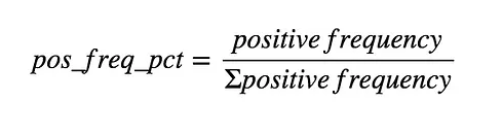

In [52]:
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

negative  positive  total  pos_rate  pos_freq_pct
to       2025      1662   3687  0.450773      0.028907
the      1691      1655   3346  0.494620      0.028785
you       672      1257   1929  0.651633      0.021863
it        984      1024   2008  0.509960      0.017810
and      1018       955   1973  0.484034      0.016610
for       671       803   1474  0.544776      0.013966
my       1066       775   1841  0.420967      0.013479
is        925       727   1652  0.440073      0.012645
in        786       658   1444  0.455679      0.011444
of        634       633   1267  0.499605      0.011010

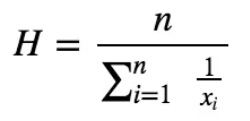

In [53]:
from scipy.stats import hmean
term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])
if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)

term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

negative  positive  total  pos_rate  pos_freq_pct  pos_hmean
the      1691      1655   3346  0.494620      0.028785   0.054404
to       2025      1662   3687  0.450773      0.028907   0.054330
you       672      1257   1929  0.651633      0.021863   0.042306
it        984      1024   2008  0.509960      0.017810   0.034418
and      1018       955   1973  0.484034      0.016610   0.032118
for       671       803   1474  0.544776      0.013966   0.027235
my       1066       775   1841  0.420967      0.013479   0.026122
is        925       727   1652  0.440073      0.012645   0.024583
in        786       658   1444  0.455679      0.011444   0.022328
of        634       633   1267  0.499605      0.011010   0.021545

In [54]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())
term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
term_freq_df2.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]

negative  positive  total  pos_rate  pos_freq_pct  pos_hmean  \
thanks         41       214    255  0.839216      0.003722   0.007411   
follow          8        56     64  0.875000      0.000974   0.001946   
hi              7        49     56  0.875000      0.000852   0.001703   
awesome        19        74     93  0.795699      0.001287   0.002570   
glad           17        69     86  0.802326      0.001200   0.002397   
thank          22        81    103  0.786408      0.001409   0.002813   
welcome         3        41     44  0.931818      0.000713   0.001425   
nice           36       118    154  0.766234      0.002052   0.004094   
happy          36       109    145  0.751724      0.001896   0.003782   
great          53       142    195  0.728205      0.002470   0.004923   

         pos_rate_normcdf  pos_freq_pct_normcdf  pos_normcdf_hmean  
thanks           0.778639              1.000000           0.875545  
follow           0.802481              0.929760           0.861445  
hi               0.802481              0.898741           0.847888  
awesome          0.747543              0.976553           0.846838  
glad             0.752422              0.967459           0.846497  
thank            0.740617              0.985624           0.845733  
welcome          0.836991              0.852288           0.844570  
nice             0.725249              0.999406           0.840537  
happy            0.713925              0.998583           0.832596  
great            0.695112              0.999957           0.820122

In [55]:
term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']
term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()
term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])
if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 else 0), axis=1)

term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])
term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])
term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

negative  positive  total  pos_rate  pos_freq_pct  pos_hmean  \
sad          157         9    166  0.054217      0.000157   0.000312   
sick         107        11    118  0.093220      0.000191   0.000382   
missed        68         7     75  0.093333      0.000122   0.000243   
hate         101        17    118  0.144068      0.000296   0.000590   
poor          59         7     66  0.106061      0.000122   0.000243   
ugh           60         8     68  0.117647      0.000139   0.000278   
wanna         64        10     74  0.135135      0.000174   0.000347   
sorry        120        31    151  0.205298      0.000539   0.001076   
cold          72        17     89  0.191011      0.000296   0.000590   
why          152        43    195  0.220513      0.000748   0.001491   

        pos_rate_normcdf  pos_freq_pct_normcdf  pos_normcdf_hmean  neg_rate  \
sad             0.146574              0.553237           0.231749  0.945783   
sick            0.168309              0.575687           0.260468  0.906780   
missed          0.168375              0.530614           0.255633  0.906667   
hate            0.199599              0.641308           0.304444  0.855932   
poor            0.175896              0.530614           0.264209  0.893939   
ugh             0.182926              0.541942           0.273526  0.882353   
wanna           0.193862              0.564488           0.288608  0.864865   
sorry           0.241594              0.776718           0.368552  0.794702   
cold            0.231387              0.641308           0.340074  0.808989   
why             0.252728              0.865057           0.391173  0.779487   

        neg_freq_pct  neg_hmean  neg_rate_normcdf  neg_freq_pct_normcdf  \
sad         0.002562   0.005110          0.853426              0.999977   
sick        0.001746   0.003485          0.831691              0.996895   
missed      0.001110   0.002217          0.831625              0.954901   
hate        0.001648   0.003290          0.800401              0.995004   
poor        0.000963   0.001923          0.824104              0.927009   
ugh         0.000979   0.001956          0.817074              0.930642   
wanna       0.001044   0.002086          0.806138              0.943797   
sorry       0.001958   0.003907          0.758406              0.998978   
cold        0.001175   0.002346          0.768613              0.964167   
why         0.002480   0.004945          0.747272              0.999959   

        neg_normcdf_hmean  
sad              0.920907  
sick             0.906830  
missed           0.889010  
hate             0.887156  
poor             0.872532  
ugh              0.870168  
wanna            0.869553  
sorry            0.862226  
cold             0.855355  
why              0.855344

Text(0.5, 1.0, 'neg_hmean vs pos_hmean')

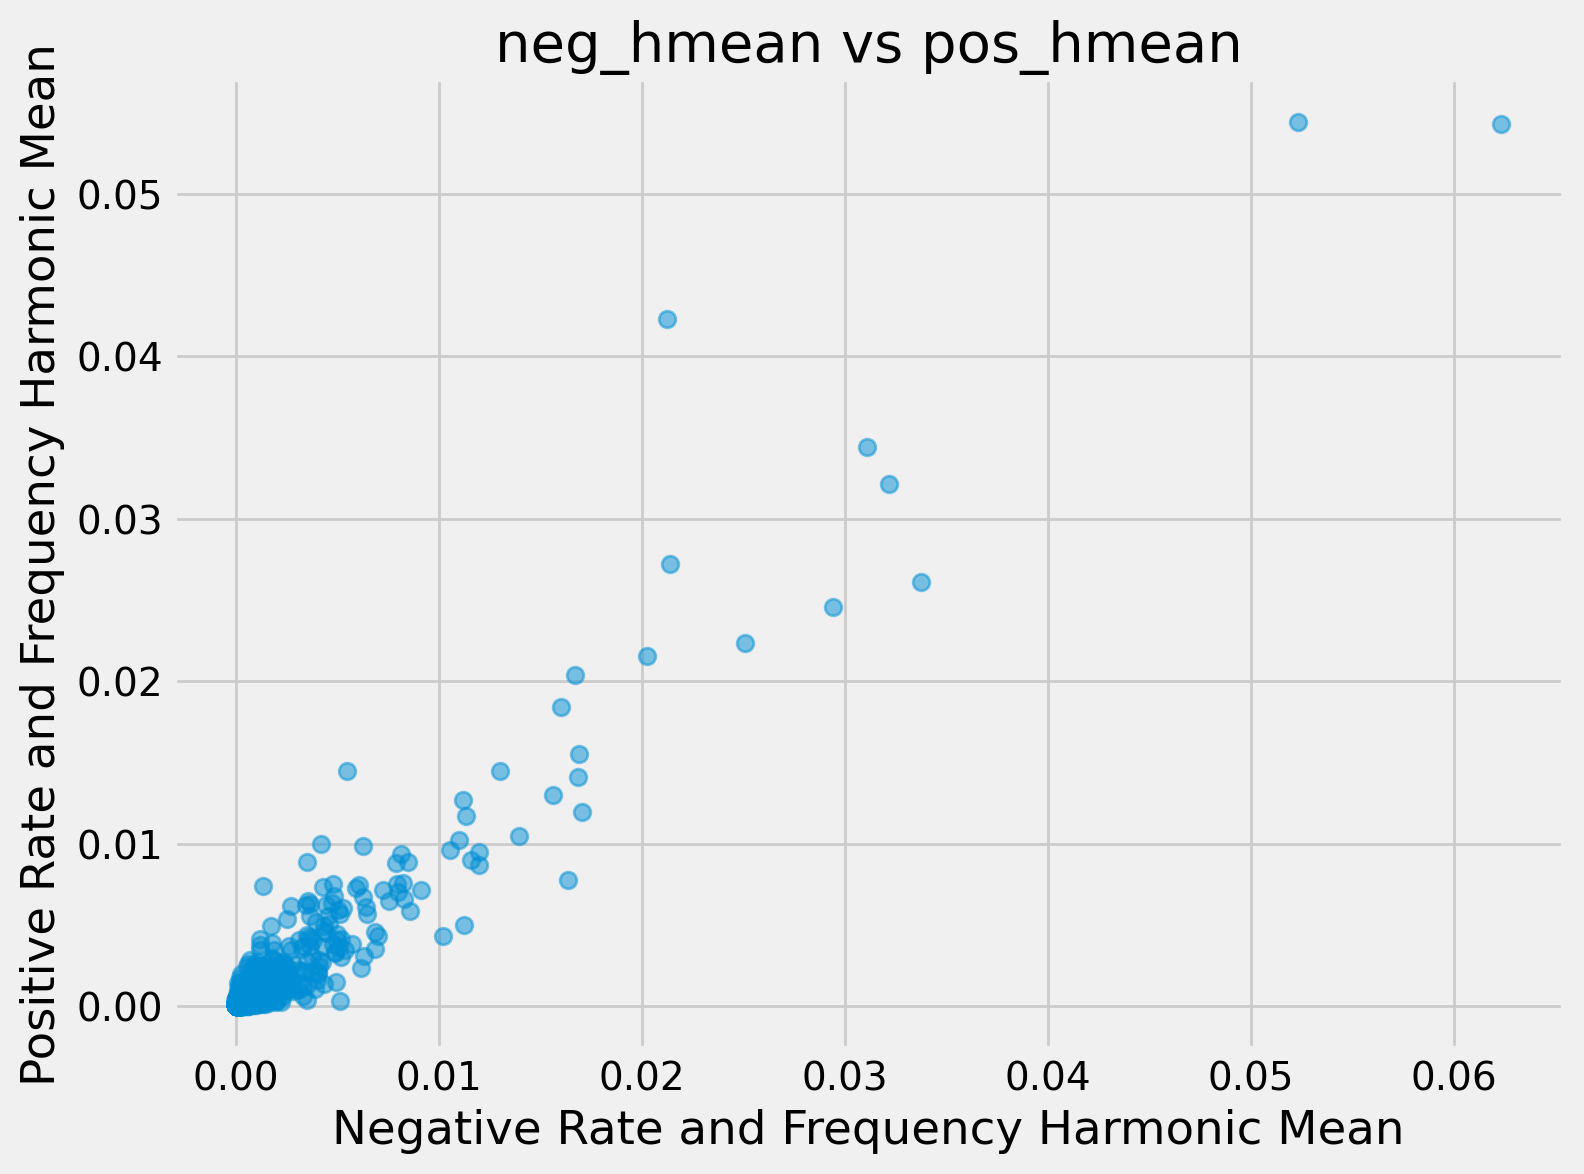

In [56]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Text(0.5, 1.0, 'neg_normcdf_hmean vs pos_normcdf_hmean')

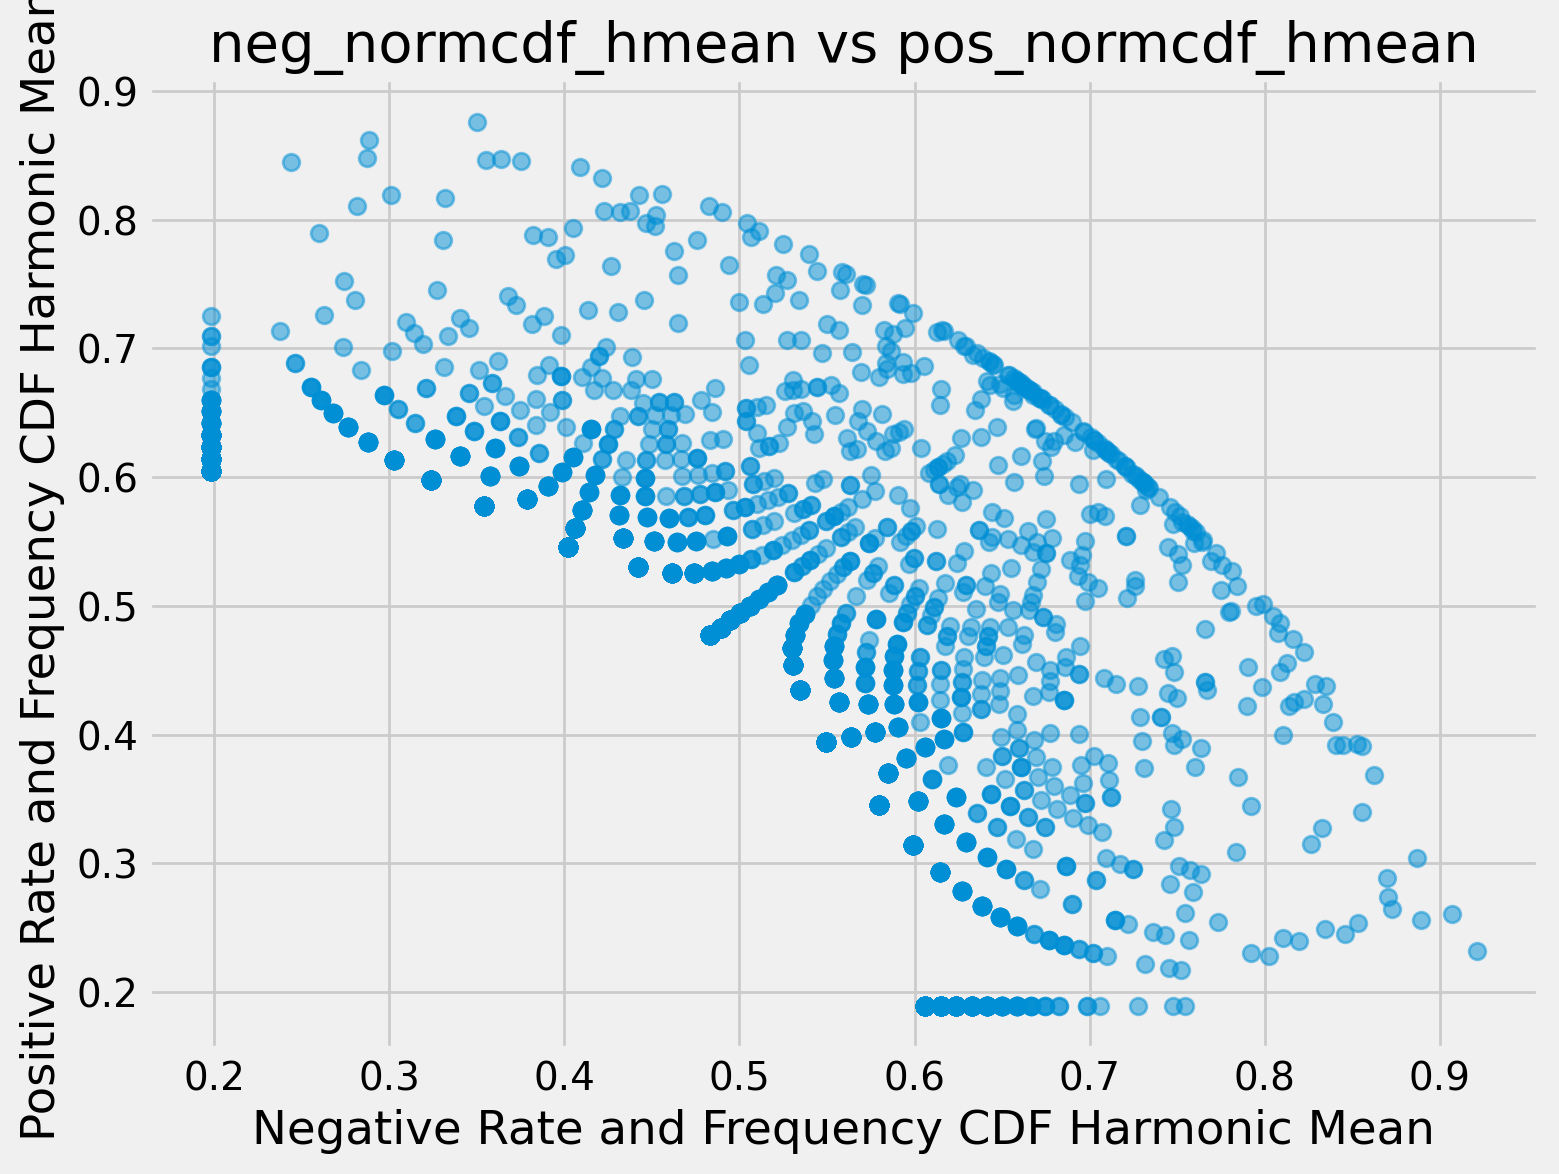

In [57]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

In [58]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_normcdf_hmean), high=max(term_freq_df2.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

Output hidden; open in https://colab.research.google.com to view.

In [59]:
# Train / Dev / Test Split

x = my_df.text
y = my_df.target
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)
print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
(len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
(len(x_train[y_train == 4]) / (len(x_train)*1.))*100))
print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
(len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
(len(x_validation[y_validation == 4]) / (len(x_validation)*1.))*100))
print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
(len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
(len(x_test[y_test == 4]) / (len(x_test)*1.))*100))

Train set has total 9770 entries with 50.04% negative, 49.96% positive
Validation set has total 100 entries with 48.00% negative, 52.00% positive
Test set has total 100 entries with 53.00% negative, 47.00% positive


In [60]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 4 for n in tbresult]
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[4,0]))
confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])
print ("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)
print ("-"*80)
print ("Classification Report\n")
print (classification_report(y_validation, tbpred))

Accuracy Score: 58.00%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                  46                   6
negative                  36                  12
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

           0       0.67      0.25      0.36        48
           4       0.56      0.88      0.69        52

    accuracy                           0.58       100
   macro avg       0.61      0.57      0.53       100
weighted avg       0.61      0.58      0.53       100



In [61]:
# COUNT VECTORIZER

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [62]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)
def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [63]:
csv = 'term_freq_df.csv'
term_freq_df = pd.read_csv(csv,index_col=0)
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

negative  positive  total
to       2025      1662   3687
the      1691      1655   3346
it        984      1024   2008
and      1018       955   1973
you       672      1257   1929
my       1066       775   1841
is        925       727   1652
for       671       803   1474
in        786       658   1444
of        634       633   1267

In [64]:
from sklearn.feature_extraction import text
a = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
b = text.ENGLISH_STOP_WORDS
set(a).issubset(set(b))

True

In [65]:
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))

In [66]:
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression()


Validation result for 10000 features
null accuracy: 52.00%
accuracy score: 68.00%
model is 16.00% more accurate than null accuracy
train and test time: 0.57s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 52.00%
accuracy score: 72.00%
model is 20.00% more accurate than null accuracy
train and test time: 0.63s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 52.00%
accuracy score: 72.00%
model is 20.00% more accurate than null accuracy
train and test time: 0.54s
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 52.00%
accuracy score: 72.00%
model is 20.00% more accurate than null accuracy
train and test time: 0.63s
---------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 69.00%
model is 17.00% more accurate than null accuracy
train and test time: 0.51s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 70.00%
model is 18.00% more accurate than null accuracy
train and test time: 0.74s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 70.00%
model is 18.00% more accurate than null accuracy
train and test time: 1.37s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 70.00%
model is 18.00% more accurate than null accuracy
train and test time: 1.41s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 70.00%
model is 18.00% more accurate than null accuracy
train and test time: 1.40s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 70.00%
model is 18.00% more accurate than null accuracy
train and test time: 0.93s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 70.00%
model is 18.00% more accurate than null accuracy
train and test time: 0.79s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 70.00%
model is 18.00% more accurate than null accuracy
train and test time: 0.74s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 70.00%
model is 18.00% more accurate than null accuracy
train and test time: 0.66s
--------------------------------------------------------------------------------
Validation result for 100000 features
null accuracy: 52.00%
accuracy score: 70.00%
model is 18.00% more accurate than null accuracy
train and test time: 0.80s
--------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
print ("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)\n")
feature_result_wocsw = nfeature_accuracy_checker(stop_words=list(my_stop_words))

RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)

LogisticRegression()


Validation result for 10000 features
null accuracy: 52.00%
accuracy score: 69.00%
model is 17.00% more accurate than null accuracy
train and test time: 0.66s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 52.00%
accuracy score: 70.00%
model is 18.00% more accurate than null accuracy
train and test time: 0.69s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 52.00%
accuracy score: 70.00%
model is 18.00% more accurate than null accuracy
train and test time: 0.83s
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 52.00%
accuracy score: 70.00%
model is 18.00% more accurate than null accuracy
train and test time: 0.78s
--------------------------------

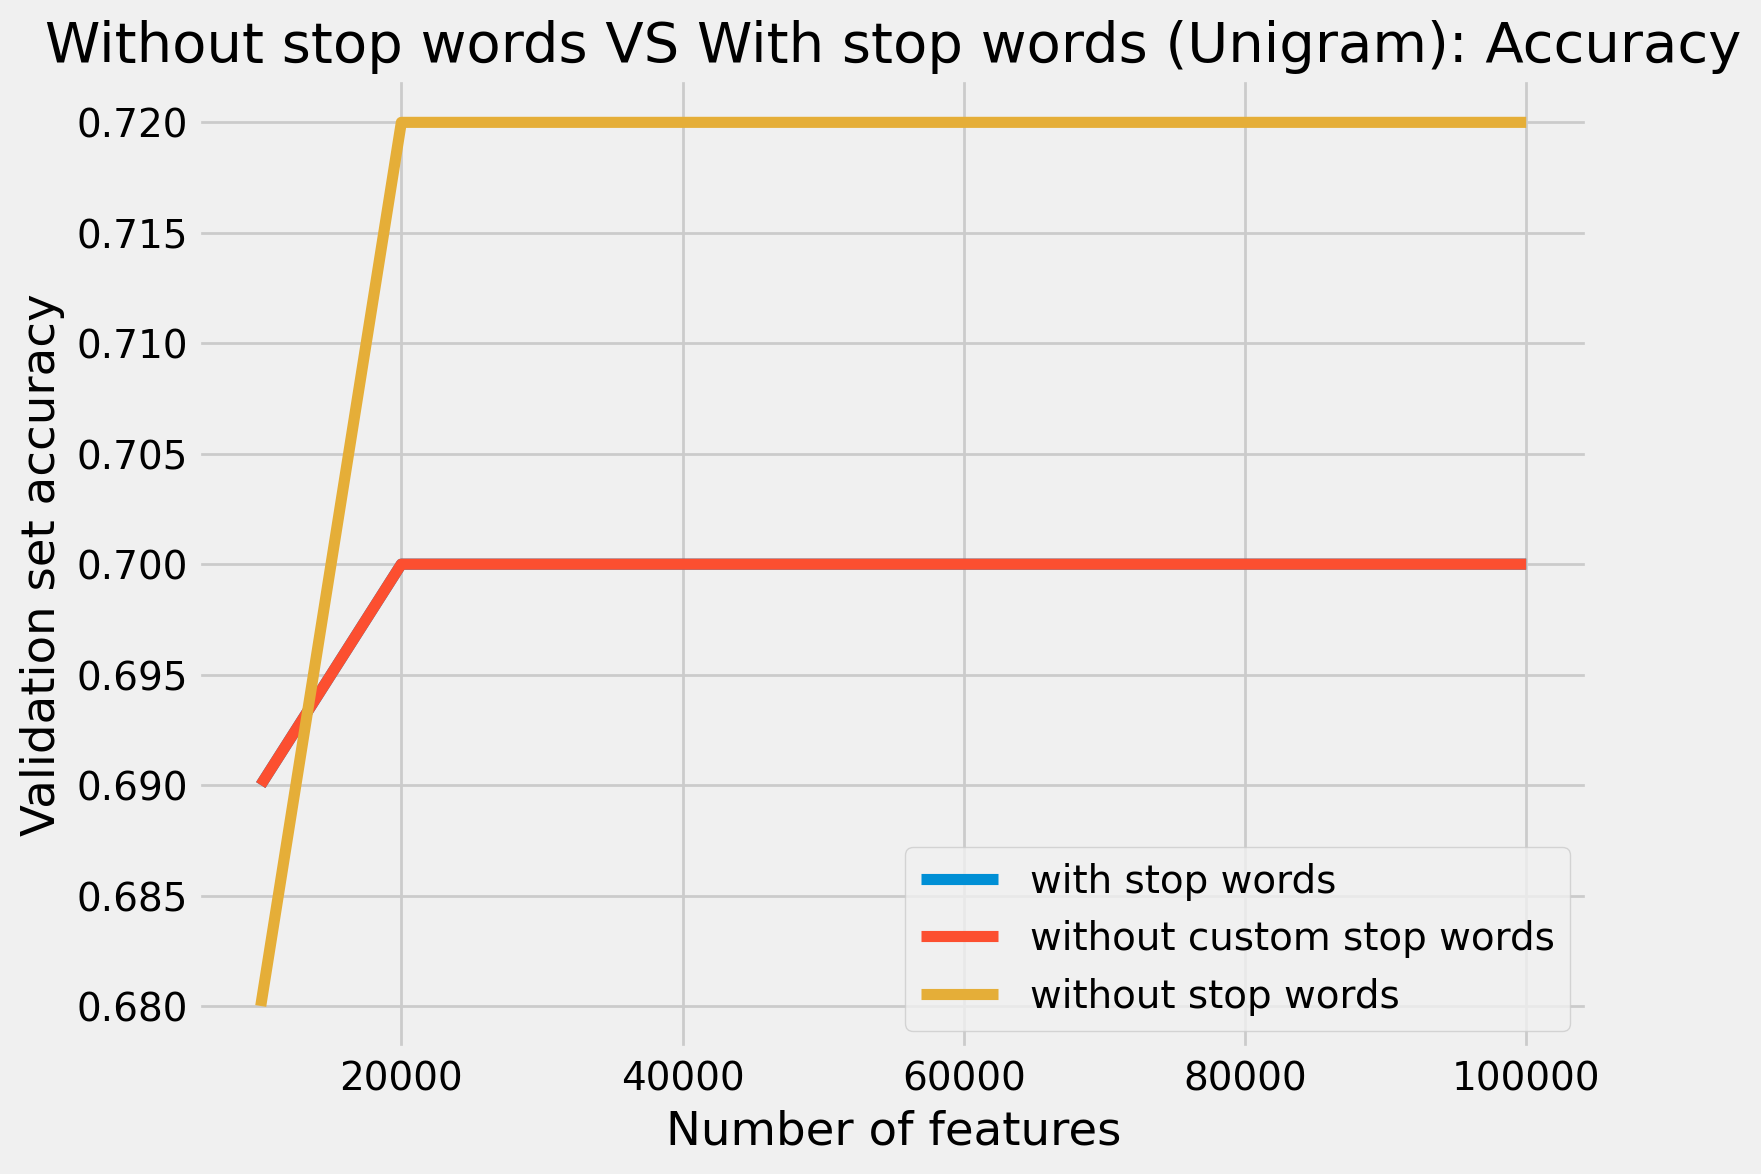

In [68]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [69]:
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression()


Validation result for 10000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 77.00%
model is 25.00% more accurate than null accuracy
train and test time: 1.31s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 76.00%
model is 24.00% more accurate than null accuracy
train and test time: 2.02s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 77.00%
model is 25.00% more accurate than null accuracy
train and test time: 1.37s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 76.00%
model is 24.00% more accurate than null accuracy
train and test time: 1.56s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 77.00%
model is 25.00% more accurate than null accuracy
train and test time: 1.83s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 76.00%
model is 24.00% more accurate than null accuracy
train and test time: 2.08s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 77.00%
model is 25.00% more accurate than null accuracy
train and test time: 2.60s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 76.00%
model is 24.00% more accurate than null accuracy
train and test time: 4.57s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 76.00%
model is 24.00% more accurate than null accuracy
train and test time: 3.44s
--------------------------------------------------------------------------------
Validation result for 100000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 76.00%
model is 24.00% more accurate than null accuracy
train and test time: 4.75s
--------------------------------------------------------------------------------
RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression()


Validation result for 10000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 79.00%
model is 27.00% more accurate than null accuracy
train and test time: 1.15s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 77.00%
model is 25.00% more accurate than null accuracy
train and test time: 2.25s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 76.00%
model is 24.00% more accurate than null accuracy
train and test time: 2.86s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 77.00%
model is 25.00% more accurate than null accuracy
train and test time: 2.05s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 76.00%
model is 24.00% more accurate than null accuracy
train and test time: 2.14s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 75.00%
model is 23.00% more accurate than null accuracy
train and test time: 2.57s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 76.00%
model is 24.00% more accurate than null accuracy
train and test time: 2.59s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 78.00%
model is 26.00% more accurate than null accuracy
train and test time: 4.93s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 52.00%
accuracy score: 77.00%
model is 25.00% more accurate than null accuracy
train and test time: 3.42s
--------------------------------------------------------------------------------
Validation result for 100000 features
null accuracy: 52.00%
accuracy score: 75.00%
model is 23.00% more accurate than null accuracy
train and test time: 3.67s
--------------------------------------------------------------------------------


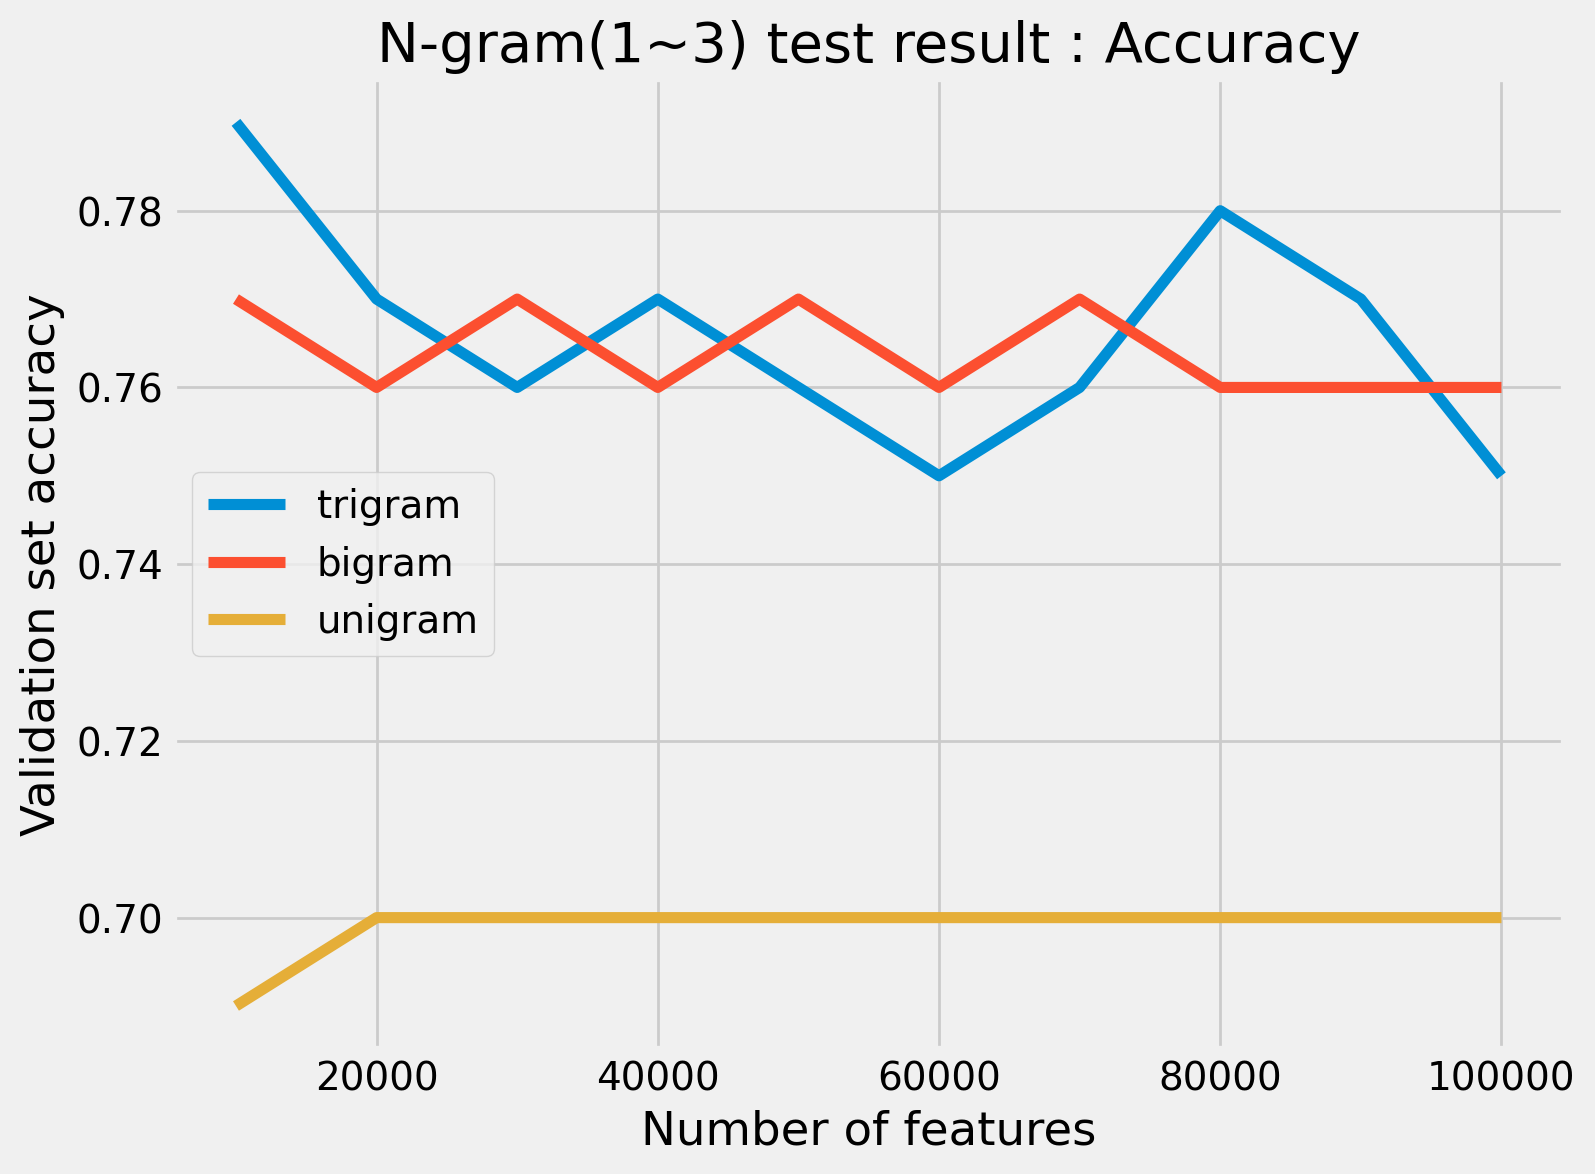

In [70]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [71]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("-"*80)
    print ("Confusion Matrix\n")
    print (confusion)
    print ("-"*80)
    print ("Classification Report\n")
    print (classification_report(y_test, y_pred, target_names=['negative','positive']))

In [72]:
# LOGISTIC REGRESSION

%%time
tg_cvec = CountVectorizer(max_features=80000,ngram_range=(1, 3))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)

null accuracy: 52.00%
accuracy score: 78.00%
model is 26.00% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                  36                   0
positive                   0                   0
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.78      0.75      0.77        48
    positive       0.78      0.81      0.79        52

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100

CPU times: user 2.78 s, sys: 2.32 s, total: 5.1 s
Wall time: 3.23 s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [79]:
# Term Frequency-Inverse Document Frequency TFIDF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer

In [80]:
names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB",
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

In [81]:
tvec = TfidfVectorizer()

In [83]:
def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

In [84]:
trigram_result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression()
null accuracy: 52.00%
accuracy score: 73.00%
model is 21.00% more accurate than null accuracy
train and test time: 2.06s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC()
null accuracy: 52.00%
accuracy score: 74.00%
model is 22.00% more accurate than null accuracy
train and test time: 0.91s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', LinearSVC())])
null accuracy: 52.00%
accuracy score: 75.00%
model is 23.00% more accurate than null accuracy
train and test time: 1.01s
--------------------------------------------------------------------------------

It looks like logistic regression is my best performing classifier.